# Prerequisites

In [1]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Prepare Data

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [29]:
def index_validate_test(data, frac_validate=.2, frac_test=.2):
  n_size = data.shape[0]
  n_validate = int(n_size*(frac_test))
  n_test = int(n_size*(frac_test))
  data.idx_validate = n_size - n_test - n_validate
  data.idx_test = n_size - n_test

  return data

In [31]:
hml = index_validate_test(hml)
hml.idx_validate

In [308]:
def data_transform(data, method=None):
  '''
  Tranform data and keep associated scaler

  Args:
    data (dataframe): a dataframe of interest
    method (str): a string indicating the transformation method default=None

  Return:
    a transformmed dataframe and a scaler
  '''
  
  idx_validate = getattr(data, "idx_validate")
  train = data.iloc[:idx_validate,]
  
  if method=="standard":
    scaler = StandardScaler().fit(train)
  elif method=="minmax":
    scaler = MinMaxScaler().fit(train)
  elif method=="log":
    scaler = LogScaler()
  elif method=="box-cox":
    scaler = PowerTransformer(method='box-cox', standardize=True)
  else:
    scaler = NoneScaler()

  scaled = pd.DataFrame(index=data.index)
  scaled["y"] = scaler.transform(data)  

  return scaled, scaler

In [309]:
n_diff = 1

for price in prices:
  price = index_validate_test(price)
  price.scaled, price.scaler = data_transform(price, method='minmax')
  price.scaled_diff = (
    price.scaled.diff(n_diff).dropna() if n_diff>0 else price.scaled
  )
  price.n_diff = n_diff
  
  print(
    price.meta.abb, 
    price.scaled.size, 
    price.scaled_diff.size
  )

hml 429 428
wht 429 428
glu 429 428


In [326]:
price.scaled

,y
date,
1984-01-01,0.1128
1984-02-01,0.1080
1984-03-01,0.0996
1984-04-01,0.1000
1984-05-01,0.0819
...,...
2019-05-01,1.4561
2019-06-01,1.5319
2019-07-01,1.5466


In [331]:
scaler = glu.scaler

In [333]:
glu.tail()

,y
date,
2019-05-01,"11,347.0000"
2019-06-01,"11,843.0000"
2019-07-01,"11,939.0000"
2019-08-01,"12,969.0000"
2019-09-01,"14,241.0000"


In [334]:
_ = price.scaled.iloc[0] + price.scaled_diff.cumsum()
# df = price.scaled
# df.iloc[1:] = _

In [336]:
# scaler.inverse_transform(_)

In [337]:
# _ = price.scaled.iloc[0] + price.scaled_diff.cumsum()
# df = price.scaled.iloc[0].append(_)

# scaler.inverse_transform(df) 

In [312]:
# scaler.inverse_transform(hml.scaled)

In [299]:
scaler = hml.scaler

In [304]:
hml.iloc[0]

y   3,024.8013
Name: 1984-01-01 00:00:00, dtype: float64

In [305]:
hml.iloc[-1]

y   16,604.0000
Name: 2019-09-01 00:00:00, dtype: float64

In [307]:
hml.iloc[1]

y   3,004.5982
Name: 1984-02-01 00:00:00, dtype: float64

In [306]:
scaler.inverse_transform(hml.scaled_diff.cumsum())

array([[ 2329.79687397],
       [ 2304.60934695],
       [ 2410.6839335 ],
       [ 2431.27999806],
       [ 2450.19867083],
       [ 2990.37337624],
       [ 2833.69487433],
       [ 2671.63609529],
       [ 2514.8050188 ],
       [ 2352.74623976],
       [ 2195.91516327],
       [ 2230.58622525],
       [ 2189.4355534 ],
       [ 2295.70999431],
       [ 2255.1562722 ],
       [ 2235.19867083],
       [ 2331.22820858],
       [ 2228.19867083],
       [ 2255.19867083],
       [ 2275.19867083],
       [ 2242.23163787],
       [ 2208.1657038 ],
       [ 2175.19867083],
       [ 2046.19867083],
       [ 2117.19867083],
       [ 1675.19867083],
       [ 1675.19867083],
       [ 1705.19867083],
       [ 2025.19867083],
       [ 2315.19867083],
       [ 2546.19867083],
       [ 2411.06682499],
       [ 2280.29407095],
       [ 2145.16222511],
       [ 2014.38947107],
       [ 1866.53814864],
       [ 2031.15586983],
       [ 2219.15283395],
       [ 2214.99572197],
       [ 2369.19867083],


In [39]:
hml_scaled, hml_scaler = data_transform(hml, 'minmax')

In [28]:
idx_validate, idx_test = index_validate_test(hml)

In [25]:
hml.diff().iloc[:idx_validate]

,y
date,
1984-01-01,nan
1984-02-01,-20.2031
1984-03-01,-25.1875
1984-04-01,106.0746
1984-05-01,20.5961
...,...
2005-03-01,80.0000
2005-04-01,97.0000
2005-05-01,-144.0000


In [24]:
hml.diff().iloc[idx_validate:idx_test]

,y
date,
2005-08-01,132.0000
2005-09-01,198.0000
2005-10-01,34.0000
2005-11-01,-457.0000
2005-12-01,186.0000
...,...
2012-04-01,-18.0000
2012-05-01,-124.0000
2012-06-01,-12.0000


In [21]:
hml.iloc[idx_test:]

,y
date,
2012-09-01,"15,538.0000"
2012-10-01,"15,813.0000"
2012-11-01,"15,302.0000"
2012-12-01,"15,386.0000"
2013-01-01,"15,702.0000"
...,...
2019-05-01,"15,726.0000"
2019-06-01,"15,771.0000"
2019-07-01,"15,508.0000"


In [ ]:
n_diff = 0

for price in prices:
  price.scaled, price.scaler = data_transform(price, method='minmax')
  price.scaled_diff = price.scaled.diff(n_diff).dropna() if n_diff>0 else price.scaled
  price.n_diff = n_diff
  price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)

In [4]:
n_diff = 0

for price in prices:
  price.scaled, price.scaler = data_transform(price, method='minmax')
  price.scaled_diff = price.scaled.diff(n_diff).dropna() if n_diff>0 else price.scaled
  price.n_diff = n_diff
  price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)

hml 259 85 85
wht 259 85 85
glu 259 85 85


In [66]:
def data_2keras(data, n_lag=12, n_forecast=4, h=None):
  """
  Rearrange data into keras format also keep time index

  Args:
    data (dataframe or series): dataframe or series with time index
    n_lag (int): number of lags to be used in the model
    n_forecast (int): number of steps to forecast
    h(int): specify a particular period in future that want to forecast

  Returns:
    x (dataframe): input for training
    y (dataframe): output for training
    date_idx: date index
  """

  df = pd.DataFrame(index=data.index)

  for i in reversed(range(n_lag+1)):
    df[f'x{i}'] = data.shift(i)

  for i in range(1, n_forecast+1):
    df[f'y{i}'] = data.shift(-i)
  
#   return df
#   df = df.dropna()
  date_idx = df.index
  x = df.iloc[:, :n_lag+1]
  y = df.iloc[:, n_lag+1:] if h is None else df.iloc[:, n_lag+h]

  return x, y, date_idx

In [69]:
x, y, idx_ = data_2keras(hml.scaled, n_lag=12, n_forecast=4, h=None)

In [71]:
x

,x12,x11,x10,x9,x8,x7,x6,x5,x4,x3,x2,x1,x0
date,,,,,,,,,,,,,
1984-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0933
1984-02-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0933,0.0905
1984-03-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0933,0.0905,0.0871
1984-04-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0933,0.0905,0.0871,0.1017
1984-05-01,nan,nan,nan,nan,nan,nan,nan,nan,0.0933,0.0905,0.0871,0.1017,0.1046
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,1.8241,1.8723,1.8866,1.7980,1.7687,1.7309,1.7883,1.7833,1.7696,1.8312,1.8493,1.8389,1.8500
2019-06-01,1.8723,1.8866,1.7980,1.7687,1.7309,1.7883,1.7833,1.7696,1.8312,1.8493,1.8389,1.8500,1.8562
2019-07-01,1.8866,1.7980,1.7687,1.7309,1.7883,1.7833,1.7696,1.8312,1.8493,1.8389,1.8500,1.8562,1.8198


In [52]:
x, y, date_idx = data_2keras(hml.scaled, n_lag=12, n_forecast=4, h=4)
x

,x12,x11,x10,x9,x8,x7,x6,x5,x4,x3,x2,x1,x0
date,,,,,,,,,,,,,
1985-01-01,0.0933,0.0905,0.0871,0.1017,0.1046,0.1072,0.1819,0.1602,0.1378,0.1161,0.0937,0.0720,0.0768
1985-02-01,0.0905,0.0871,0.1017,0.1046,0.1072,0.1819,0.1602,0.1378,0.1161,0.0937,0.0720,0.0768,0.0711
1985-03-01,0.0871,0.1017,0.1046,0.1072,0.1819,0.1602,0.1378,0.1161,0.0937,0.0720,0.0768,0.0711,0.0858
1985-04-01,0.1017,0.1046,0.1072,0.1819,0.1602,0.1378,0.1161,0.0937,0.0720,0.0768,0.0711,0.0858,0.0802
1985-05-01,0.1046,0.1072,0.1819,0.1602,0.1378,0.1161,0.0937,0.0720,0.0768,0.0711,0.0858,0.0802,0.0775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,1.5226,1.6770,1.7642,1.7822,1.8241,1.8723,1.8866,1.7980,1.7687,1.7309,1.7883,1.7833,1.7696
2019-02-01,1.6770,1.7642,1.7822,1.8241,1.8723,1.8866,1.7980,1.7687,1.7309,1.7883,1.7833,1.7696,1.8312
2019-03-01,1.7642,1.7822,1.8241,1.8723,1.8866,1.7980,1.7687,1.7309,1.7883,1.7833,1.7696,1.8312,1.8493


In [53]:
def mlp_fit(data, config, n_forecast=4, h=None):

  # unpack config
  n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
  
  # transform to keras format
  x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast, h=h)
  x = x.to_numpy()
  y = y.to_numpy()
  
  n_input = x.shape[1]
  n_output = n_forecast if h is None else 1

  # define model
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
  if n_layers==2:
    model.add(Dense(n_nodes, activation='relu'))
  elif n_layers==3:
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(n_output))
  model.compile(loss='mse', optimizer='adam')
  
  # fit model
  model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)

  return model

date
1985-01-01   0.0775
1985-02-01   0.0907
1985-03-01   0.0765
1985-04-01   0.0802
1985-05-01   0.0830
              ...  
2019-01-01   1.8500
2019-02-01   1.8562
2019-03-01   1.8198
2019-04-01   1.8927
2019-05-01   1.9714
Freq: MS, Name: y4, Length: 413, dtype: float64

# MLP

In [9]:
def mlp_fit(data, config, n_forecast=4, h=None):

  # unpack config
  n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
  
  # transform to keras format
  x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast, h=h)
  x = x.to_numpy()
  y = y.to_numpy()
  n_input = x.shape[1]
  n_output = n_forecast if h is None else 1

  # define model
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
  if n_layers==2:
    model.add(Dense(n_nodes, activation='relu'))
  elif n_layers==3:
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(n_output))
  model.compile(loss='mse', optimizer='adam')
  
  # fit model
  model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)

  return model


def mlp_forecast(model_fitted, data, date, n_forecast=4, h=None):
  """
  Forecast MLP model

  Args:
      model_fitted (model): Keras fitted model
      data (dataframe): number of lags to be used in the model
      date (date): date when making the forecast
      n_forecast (int): number of steps to forecast

  Returns:

  """
  n_diff = getattr(data, "n_diff")
  scaler = getattr(data, "scaler")
  
  x_idx = data.scaled_diff.index.get_loc(date)
  x_idx = x_idx+1 if n_diff > 1 else x_idx
  x_t = data.scaled.iloc[x_idx].to_numpy()
  n_input  = model_fitted.input_shape[1]
  n_output = model_fitted.output_shape[1]

  # find-input
  x = data.scaled_diff.iloc[x_idx-n_input:x_idx,]
  x_input = x.to_numpy().reshape(1,-1)

  # forecast
  yhat = model_fitted.predict(x_input, verbose=0).reshape(-1,)
  yhat = x_t + yhat.cumsum() if n_diff == 1 else yhat # diff adjustment
  if h is None:
    yhat_idx = pd.date_range(date, periods=n_forecast+1, freq='MS')[1:]
  else:
    yhat_idx = [pd.date_range(date, periods=n_forecast+1, freq='MS')[h]]
  df = pd.DataFrame(yhat,
                    columns=["yhat_scaled"],
                    index=yhat_idx
                   )
  df['yhat'] = scaler.inverse_transform(df)
  return df['yhat'] 


def mlp_walk_forward(data, config, search_mode=False, n_forecast=4, method='joint'):

  train, test = select_traintest(data, search_mode)
  data_ = pd.concat([train,test])
  N = data_.shape[0]
  n_test = test.shape[0]
  n_yhat = n_test+1
  yhat = np.empty((n_yhat, n_forecast))
  refit_rate = config[-1]
  
  history = train
  if method == 'joint':
    model_fitted = mlp_fit(history, config, n_forecast=n_forecast)
    date = train.index[-1]
    for i in range(n_yhat):
      model_fitted = mlp_fit(history, config, n_forecast=n_forecast) if i%refit_rate==0 else model_fitted 
      yhat[i] = mlp_forecast(model_fitted, data, date, n_forecast=n_forecast)
      if i < n_yhat-1:
        history = history.append(test.iloc[i])
        date = test.index[i]
        
  elif method == 'seperated':
    model_fitted = [mlp_fit(history, config, n_forecast=n_forecast, h=h+1) for h in range(n_forecast)]
    date = train.index[-1]
    for i in range(n_yhat):
      model_fitted = [mlp_fit(history, config, n_forecast=n_forecast, h=h+1) for h in range(n_forecast)] if i%refit_rate==0 else model_fitted
      yhat_ = [mlp_forecast(model_fitted[h], data, date, n_forecast=4, h=h+1) for h in range(n_forecast)]
      yhat[i] = pd.concat(yhat_)
      K.clear_session()
      if i < n_yhat-1:
        history = history.append(test.iloc[i])
        date = test.index[i]
      
  yhat = pd.DataFrame(yhat,
                      columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                      index=data_.index[-n_test-1:])
  
  return yhat

In [579]:
res = mlp_walk_forward(hml, config, search_mode=False, n_forecast=4, method='seperated')

In [581]:
# res

In [496]:
n_lag = 11
n_layers = 2
n_nodes = 500
n_epochs = 20
n_batch = 128
refit_rate = np.inf
h = 2

config = (n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate)

In [234]:
K.clear_session()

h = None # forecast all periods
n_forecast = 4
n_lag = 6
n_layers = 2
n_nodes = 100
n_epochs = 30
n_batch = 256
refit_rate = np.inf
data = hml
idx_validate = data.idx_validate
idx_test = data.idx_test
n_diff = data.n_diff

# transform to keras format
x, y, date_idx = data_2keras(
  data.scaled_diff, n_lag=n_lag, n_forecast=n_forecast, h=h
)

x_train = x.iloc[n_lag:idx_validate,].to_numpy()
y_train = y.iloc[n_lag:idx_validate,].to_numpy()
x_validate = x.iloc[idx_validate:idx_test,].to_numpy()
y_validate = y.iloc[idx_validate:idx_test,].to_numpy()
x_test = x.iloc[idx_test:-n_forecast,].to_numpy()
y_test = y.iloc[idx_test:-n_forecast,].to_numpy()

n_input = x.shape[1]
n_output = n_forecast if h is None else 1

In [235]:
(x_train.shape, x_validate.shape, x_test.shape)

((253, 7), (85, 7), (80, 7))

In [233]:
# define model
model = Sequential()
model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
model.add(Dense(n_nodes, activation='relu'))
# model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(n_output))
model.compile(loss='mse', 
              optimizer='adam'
             )

# fit model
history = model.fit(x_train, y_train,
                    epochs=n_epochs, batch_size=n_batch, 
                    verbose=0,
                    validation_data=(x_validate, y_validate),
                    shuffle=False,
                    use_multiprocessing=True
                   )

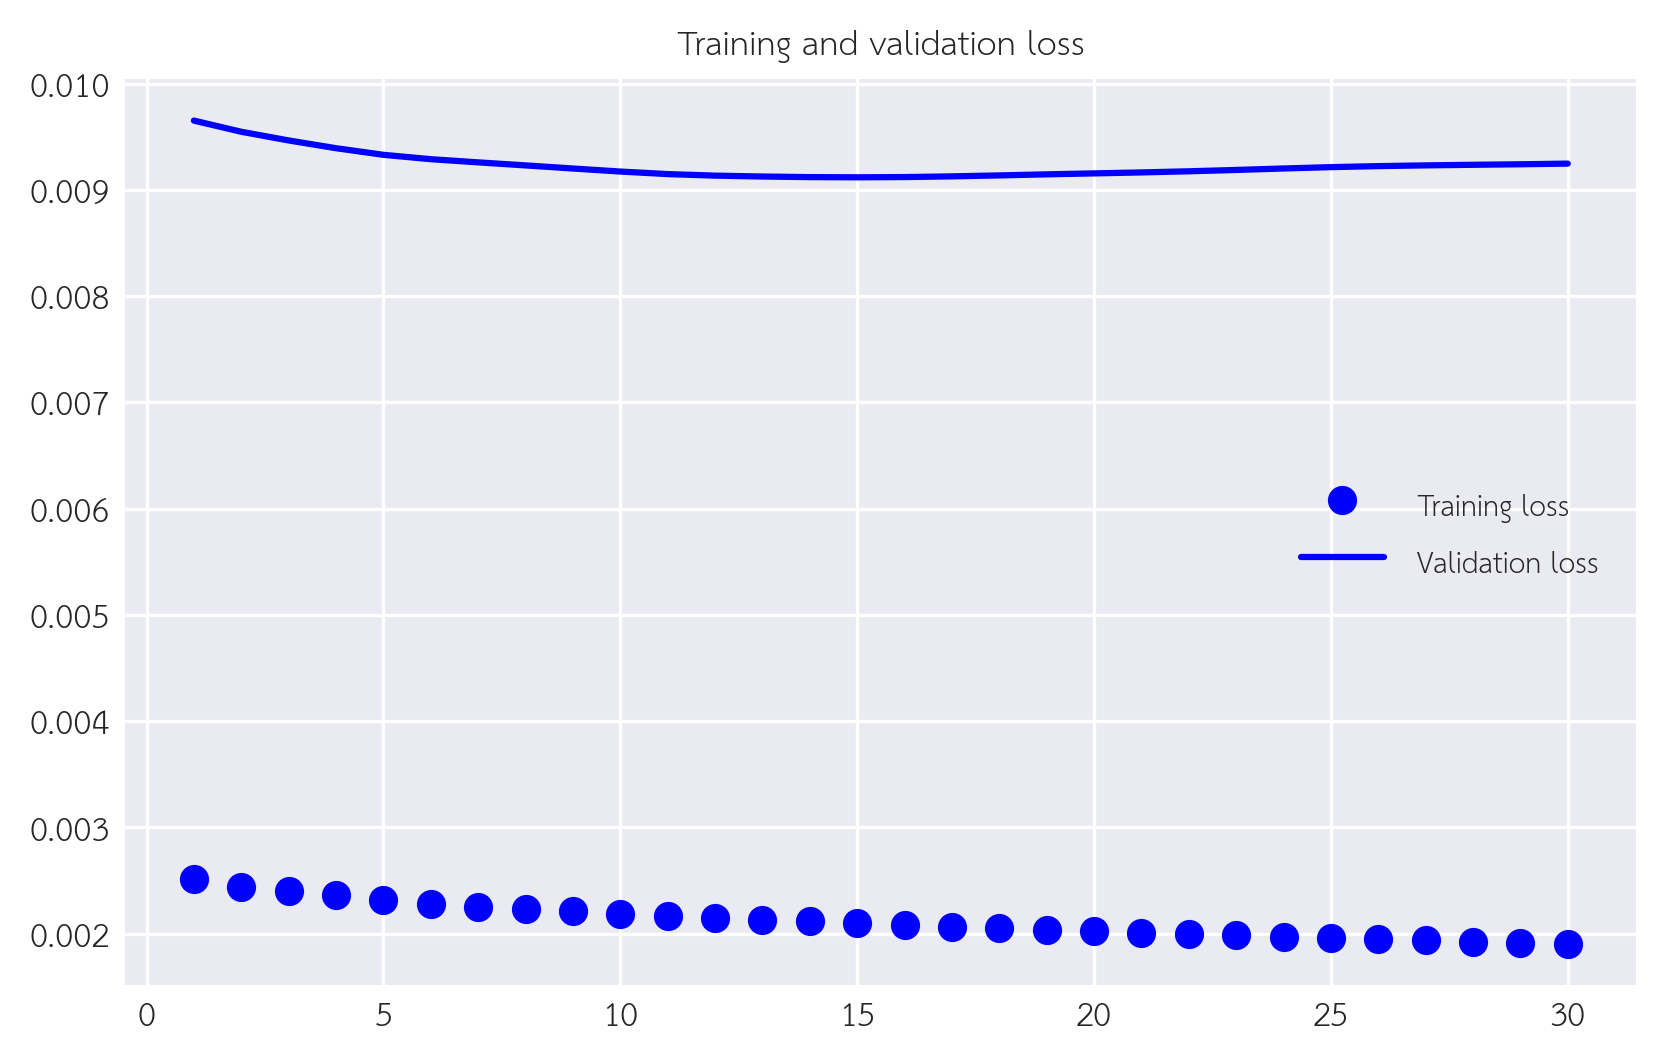

In [222]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.ylim(0.008,0.01)
plt.legend()
plt.show()

In [358]:
scaler = hml.scaler

In [281]:
y_test[0].cumsum()

array([-0.07067457, -0.05905683, -0.01535201,  0.03554474])

In [270]:
x_test[:,-1]

array([ 0.03803426, -0.07067457,  0.01161774,  0.04370482,  0.05089675,
       -0.02876773, -0.0302891 ,  0.02295886,  0.00843669, -0.04066208,
        0.01369233,  0.01396895, -0.00940483, -0.10013383, -0.09280359,
       -0.00843669, -0.00401089, -0.00511734, -0.03927902, -0.00774516,
       -0.00470242,  0.01023467,  0.01466048,  0.01410725,  0.01175604,
       -0.11230479, -0.23761039,  0.12668866,  0.07440884,  0.06472739,
       -0.01396895, -0.01784153, -0.02862942, -0.00497903, -0.00345766,
        0.02890604, -0.02531007, -0.14950921, -0.0691532 , -0.08298384,
       -0.01659677, -0.01009637, -0.01894798,  0.0432899 ,  0.02226733,
        0.00940483, -0.01673507, -0.04301329, -0.16333985, -0.16914872,
        0.12281608,  0.00802177,  0.00940483, -0.00663871, -0.02323547,
        0.00622379,  0.04163023,  0.0908673 ,  0.05283304,  0.11963503,
        0.02613991, -0.06790844,  0.17468098,  0.14605155,  0.15434994,
        0.08727134,  0.01797983,  0.04190684,  0.04813063,  0.01

In [366]:
x.iloc[idx_test:-n_forecast,]

,x6,x5,x4,x3,x2,x1,x0
date,,,,,,,
2012-10-01,-0.0025,-0.0171,-0.0017,0.0299,0.0743,0.0234,0.0380
2012-11-01,-0.0171,-0.0017,0.0299,0.0743,0.0234,0.0380,-0.0707
2012-12-01,-0.0017,0.0299,0.0743,0.0234,0.0380,-0.0707,0.0116
2013-01-01,0.0299,0.0743,0.0234,0.0380,-0.0707,0.0116,0.0437
2013-02-01,0.0743,0.0234,0.0380,-0.0707,0.0116,0.0437,0.0509
...,...,...,...,...,...,...,...
2019-01-01,0.0144,-0.0887,-0.0293,-0.0378,0.0574,-0.0050,-0.0137
2019-02-01,-0.0887,-0.0293,-0.0378,0.0574,-0.0050,-0.0137,0.0615
2019-03-01,-0.0293,-0.0378,0.0574,-0.0050,-0.0137,0.0615,0.0181


In [368]:
hml.scaled.iloc[idx_test+1:-n_forecast]

,y
date,
2012-10-01,1.8620
2012-11-01,1.7913
2012-12-01,1.8030
2013-01-01,1.8467
2013-02-01,1.8976
...,...
2019-01-01,1.7696
2019-02-01,1.8312
2019-03-01,1.8493


In [400]:
index_ = pd.date_range(hml.index[idx_test+1], periods = 80, freq = 'MS')
_ = hml.scaled.iloc[idx_test+1:-n_forecast].to_numpy() + yhat.cumsum(1)
df = pd.DataFrame(data = scaler.inverse_transform(_), index = index_)
df

,0,1,2,3
2012-10-01,"15,863.7428","15,765.7938","15,707.6308","15,696.3378"
2012-11-01,"15,067.1912","15,091.0026","15,170.2996","15,254.0980"
2012-12-01,"15,480.4709","15,525.6293","15,495.4868","15,553.9578"
2013-01-01,"15,881.7767","15,842.1995","15,837.5334","15,789.6902"
2013-02-01,"16,085.5699","16,101.0355","16,029.2938","16,017.6957"
...,...,...,...,...
2019-01-01,"15,120.3404","15,164.6700","15,205.7193","15,279.5622"
2019-02-01,"15,793.9460","15,790.3589","15,817.1649","15,831.8054"
2019-03-01,"15,653.3111","15,600.2914","15,553.1860","15,606.4936"
2019-04-01,"15,607.4700","15,618.4017","15,647.3742","15,659.4720"


In [407]:
hml.iloc[-4:]

,y
date,
2019-06-01,"15,771.0000"
2019-07-01,"15,508.0000"
2019-08-01,"16,035.0000"
2019-09-01,"16,604.0000"


In [379]:
hml.iloc[idx_test+1:]

,y
date,
2012-10-01,"15,813.0000"
2012-11-01,"15,302.0000"
2012-12-01,"15,386.0000"
2013-01-01,"15,702.0000"
2013-02-01,"16,070.0000"
...,...
2019-05-01,"15,726.0000"
2019-06-01,"15,771.0000"
2019-07-01,"15,508.0000"


In [382]:
scaler.inverse_transform(fcast).shape

(80, 4)

In [282]:
yhat[0].cumsum()

array([ 0.00701806, -0.00652892, -0.01457323, -0.01613513], dtype=float32)

In [286]:
scaler.inverse_transform(x_test)

array([[2332., 2226., 2338., 2566., 2887., 2519., 2625.],
       [2226., 2338., 2566., 2887., 2519., 2625., 1839.],
       [2338., 2566., 2887., 2519., 2625., 1839., 2434.],
       [2566., 2887., 2519., 2625., 1839., 2434., 2666.],
       [2887., 2519., 2625., 1839., 2434., 2666., 2718.],
       [2519., 2625., 1839., 2434., 2666., 2718., 2142.],
       [2625., 1839., 2434., 2666., 2718., 2142., 2131.],
       [1839., 2434., 2666., 2718., 2142., 2131., 2516.],
       [2434., 2666., 2718., 2142., 2131., 2516., 2411.],
       [2666., 2718., 2142., 2131., 2516., 2411., 2056.],
       [2718., 2142., 2131., 2516., 2411., 2056., 2449.],
       [2142., 2131., 2516., 2411., 2056., 2449., 2451.],
       [2131., 2516., 2411., 2056., 2449., 2451., 2282.],
       [2516., 2411., 2056., 2449., 2451., 2282., 1626.],
       [2411., 2056., 2449., 2451., 2282., 1626., 1679.],
       [2056., 2449., 2451., 2282., 1626., 1679., 2289.],
       [2449., 2451., 2282., 1626., 1679., 2289., 2321.],
       [2451.,

In [283]:
scaler.inverse_transform(yhat[0].cumsum())

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.00701806 -0.00652892 -0.01457323 -0.01613513].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [255]:
scaler.inverse_transform(yhat.cumsum(1))

array([[2400.7427, 2302.7937, 2244.6309, 2233.3376],
       [2115.1914, 2139.0024, 2218.2996, 2302.098 ],
       [2444.471 , 2489.6292, 2459.4868, 2517.9578],
       [2529.7766, 2490.1995, 2485.5334, 2437.6902],
       [2365.5698, 2381.0356, 2309.294 , 2297.6956],
       [2240.9573, 2196.451 , 2226.7937, 2202.3665],
       [2247.2188, 2277.4006, 2355.6284, 2459.3687],
       [2486.154 , 2496.9966, 2497.6826, 2475.1145],
       [2370.0232, 2405.199 , 2402.456 , 2407.477 ],
       [2187.476 , 2212.4014, 2184.34  , 2217.712 ],
       [2445.1199, 2428.0115, 2408.2615, 2429.325 ],
       [2355.5828, 2359.866 , 2346.95  , 2405.499 ],
       [2337.3193, 2347.4558, 2396.028 , 2461.7876],
       [2130.4854, 2276.869 , 2392.813 , 2480.9204],
       [2358.334 , 2643.5703, 2720.1409, 2759.4133],
       [2528.2588, 2644.52  , 2684.1177, 2689.2937],
       [2352.5127, 2406.4197, 2430.6948, 2476.276 ],
       [2369.9067, 2395.505 , 2491.1638, 2564.3223],
       [2342.6008, 2465.8   , 2496.3088, 2562.

In [239]:
yhat = model.predict(x_test, verbose=0)
yhat.shape

(80, 4)

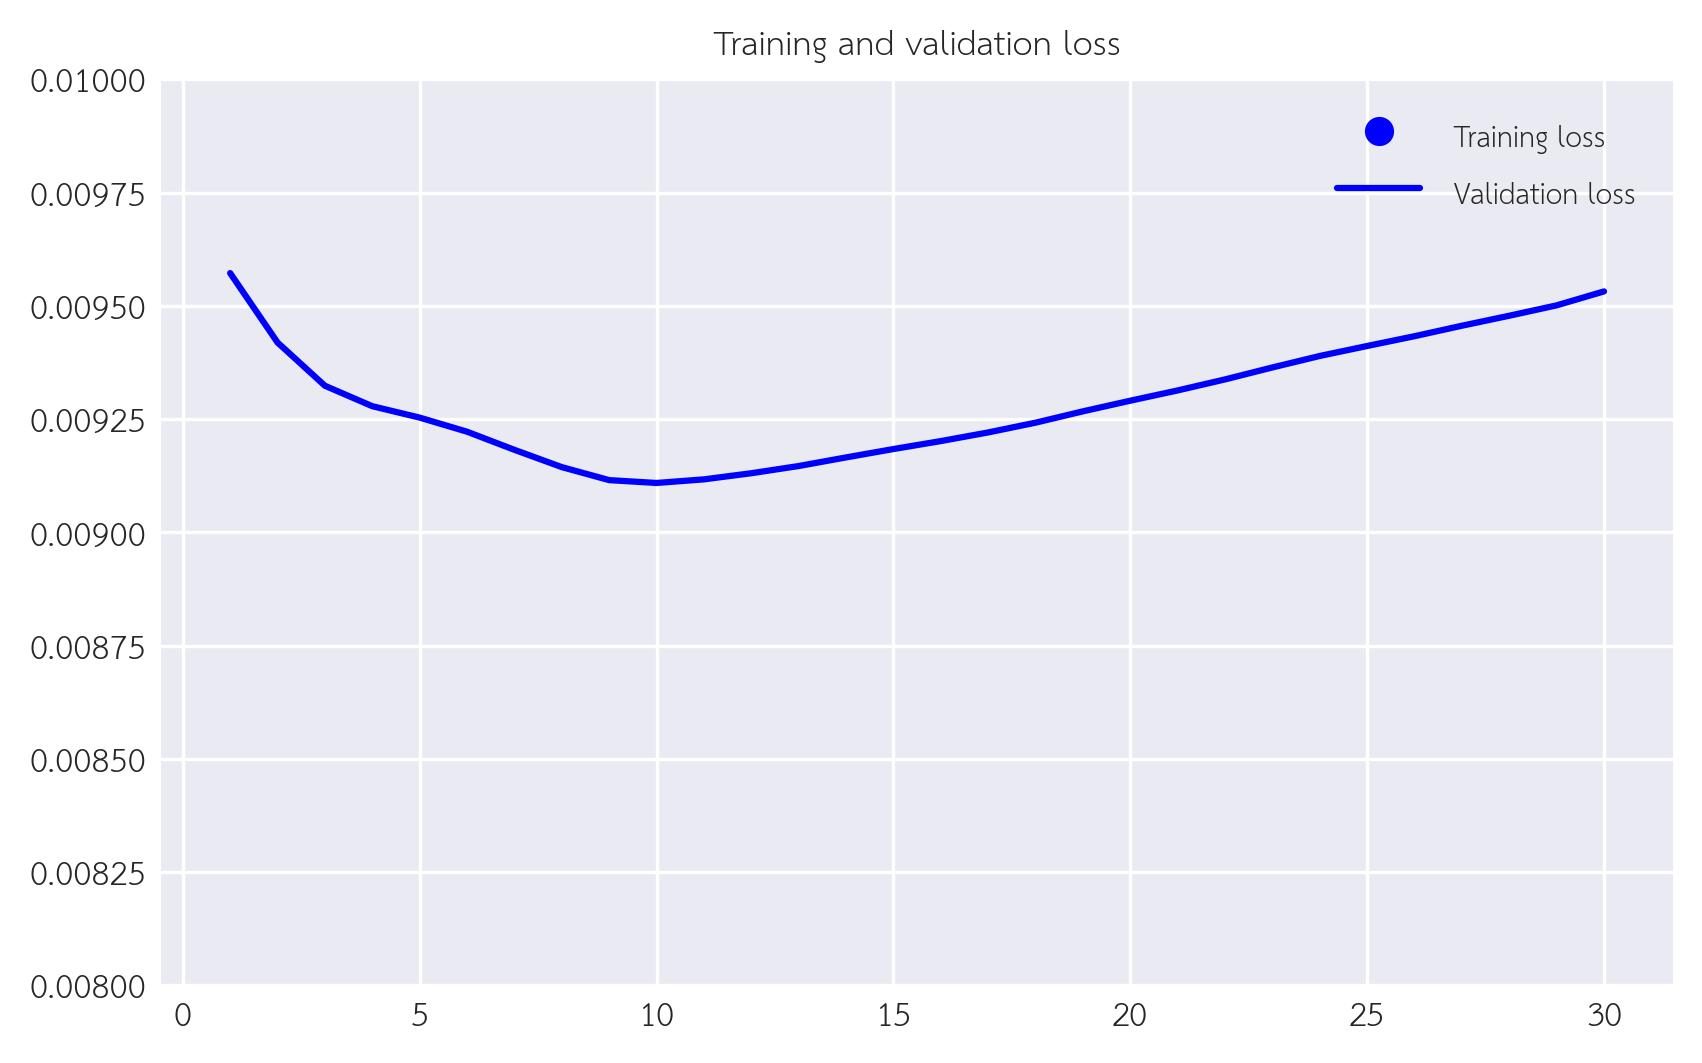

In [189]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim(0.008,0.01)
plt.legend()
plt.show()

In [578]:
n_diff = 0

for price in prices:
  price.scaled, price.scaler = data_transform(price, method='minmax')
  price.scaled_diff = price.scaled.diff(n_diff).dropna() if n_diff>0 else price.scaled
  price.n_diff = n_diff
  price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)
  
n_input = 24
n_layers = 2
n_nodes = 500
n_epochs = 60
n_batch = 128
refit_rate = np.inf
h = 2

config = (n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
fitted = [mlp_fit(hml.train, config, n_forecast=4, h=1), 
          mlp_fit(hml.train, config, n_forecast=4, h=2), 
         ]
mlp_forecast(fitted[1], hml, '2019-09-01', n_forecast=4, h=h)

hml 259 85 85
wht 259 85 85
glu 259 85 85


2019-11-01   13,497.7266
Name: yhat, dtype: float32

In [576]:
hml.scaled

,y
date,
1984-01-01,0.0452
1984-02-01,0.0438
1984-03-01,0.0421
1984-04-01,0.0492
1984-05-01,0.0506
...,...
2019-05-01,0.8952
2019-06-01,0.8982
2019-07-01,0.8806


## Config Test

In [445]:
n_input = 24
n_layers = 2
n_nodes = 500
n_epochs = 60
n_batch = 128
refit_rate = np.inf
h = 2

config = (n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
fitted = mlp_fit(hml.train, config, n_forecast=4, h=h)
mlp_forecast(fitted, hml, '2018-09-01', n_forecast=4, h=h)

,yhat_scaled,yhat
2018-11-01,0.8722,"15,382.7090"


In [444]:
hml['2018-12']

,y
date,
2018-12-01,"15,244.0000"


## Define functions
- mlp_fit
- mlp_forecast
- mlp_walk_forward

In [299]:
def mlp_walk_forward(data, config, search_mode=False, n_forecast=4):

  train, test = select_traintest(data, search_mode)
  data_ = pd.concat([train,test])
  N = data_.shape[0]
  n_test = test.shape[0]
  n_yhat = n_test+1
  yhat = np.empty((n_yhat, n_forecast))
  refit_rate = config[-1]
  
  history = train
  model_fitted = mlp_fit(history, config, n_forecast=n_forecast)
  date = train.index[-1]
  for i in range(n_yhat):
    model_fitted = mlp_fit(history, config, n_forecast=n_forecast) if i%refit_rate==0 else model_fitted 
    yhat[i] = mlp_forecast(model_fitted, data, date, n_forecast=n_forecast)
    if i < n_yhat-1:
      history = history.append(test.iloc[i])
      date = test.index[i]
      
  yhat = pd.DataFrame(yhat,
                      columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                      index=data_.index[-n_test-1:])

  return yhat

In [312]:
# K.clear_session()

# n_forecast = 4
# n_lag = 12
# n_month = 11
# n_nodes = 500
# n_batch = 256
# refit_rate = 12
# n_epochs = 50

# # transform to keras format
# data = hml
# x, y, date_idx = data_2keras(data.train, n_lag=n_lag, n_forecast=n_forecast)
# x = x.to_numpy()
# y = y.to_numpy()

# x_val, y_val, date_idx_val = data_2keras(data.validate, n_lag=n_lag, n_forecast=n_forecast)

# # define model
# model = Sequential()
# model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
# model.add(Dense(n_nodes, activation='relu'))
# model.add(Dense(n_forecast))
# model.compile(loss='mae', optimizer='adam')

# # # fit model
# history = model.fit(x, y,
#                     epochs=n_epochs, batch_size=n_batch, 
#                     verbose=2,
#                     validation_data=(x_val, y_val))

# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

## Generate Parameter Grid

In [598]:
n_input = [6, 12, 24]
n_layers = [1, 2]
n_nodes = [250, 500]
n_epochs = [10]
n_batch = [128]
refit_rate = [np.inf]

mlp_configs = model_configs(n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
mlp_model = [mlp_fit, mlp_forecast, mlp_walk_forward, mlp_configs]
mlp_configs

[(2, 1, 100, 20, 128, inf),
 (2, 1, 250, 20, 128, inf),
 (2, 1, 500, 20, 128, inf),
 (2, 2, 100, 20, 128, inf),
 (2, 2, 250, 20, 128, inf),
 (2, 2, 500, 20, 128, inf),
 (12, 1, 100, 20, 128, inf),
 (12, 1, 250, 20, 128, inf),
 (12, 1, 500, 20, 128, inf),
 (12, 2, 100, 20, 128, inf),
 (12, 2, 250, 20, 128, inf),
 (12, 2, 500, 20, 128, inf),
 (24, 1, 100, 20, 128, inf),
 (24, 1, 250, 20, 128, inf),
 (24, 1, 500, 20, 128, inf),
 (24, 2, 100, 20, 128, inf),
 (24, 2, 250, 20, 128, inf),
 (24, 2, 500, 20, 128, inf)]

In [ ]:
%%time
n_forecast = 4
npr.seed(1305)
for price in prices:
  price.mlp_grid_result, price.mlp_config = grid_search(price, mlp_model, n_forecast=n_forecast)
  price.mlp_yhat = forecast(price, mlp_model, price.mlp_config, n_forecast=n_forecast)

{('2-1-100-20-128-inf',): {'rmse': 3249.6297, 'mae': 2748.7971, 'mape': 0.2106}}
{('2-1-250-20-128-inf',): {'rmse': 2570.0556, 'mae': 2058.9543, 'mape': 0.1588}}
{('2-1-500-20-128-inf',): {'rmse': 2257.1064, 'mae': 1691.0352, 'mape': 0.1286}}
{('2-2-100-20-128-inf',): {'rmse': 1909.1398, 'mae': 1323.0025, 'mape': 0.1002}}
{('2-2-250-20-128-inf',): {'rmse': 1791.5359, 'mae': 1193.4756, 'mape': 0.0914}}
{('2-2-500-20-128-inf',): {'rmse': 1667.639, 'mae': 1051.9333, 'mape': 0.0801}}
{('12-1-100-20-128-inf',): {'rmse': 2513.4821, 'mae': 1898.1666, 'mape': 0.1465}}
{('12-1-250-20-128-inf',): {'rmse': 2354.3243, 'mae': 1724.6379, 'mape': 0.1322}}
{('12-1-500-20-128-inf',): {'rmse': 2018.6186, 'mae': 1355.1841, 'mape': 0.1032}}
{('12-2-100-20-128-inf',): {'rmse': 1863.0865, 'mae': 1226.6651, 'mape': 0.0931}}
{('12-2-250-20-128-inf',): {'rmse': 1878.7589, 'mae': 1237.4558, 'mape': 0.0942}}
{('12-2-500-20-128-inf',): {'rmse': 1885.9515, 'mae': 1273.5462, 'mape': 0.0973}}
{('24-1-100-20-128-inf'

In [595]:
for price in prices:
  print(price.mlp_config)

(24, 2, 500, 10, 128, inf)
(24, 2, 500, 10, 128, inf)
(12, 2, 500, 10, 128, inf)


In [239]:
hml.mlp_yhat

,yhat1,yhat2,yhat3,yhat4
date,,,,
2012-08-01,"15,688.2287","15,949.0151","16,121.4170","16,068.9368"
2012-09-01,"15,835.8381","16,006.2435","15,965.3571","15,802.1307"
2012-10-01,"16,031.1525","16,089.2506","16,021.2716","15,815.9985"
2012-11-01,"15,118.8547","15,057.9924","15,011.2360","15,031.8277"
2012-12-01,"15,448.4310","15,485.7017","15,414.0533","15,467.3528"
...,...,...,...,...
2019-05-01,"15,873.8633","15,841.8249","15,616.0188","15,544.6092"
2019-06-01,"15,773.0569","15,680.3780","15,611.9302","15,600.9963"
2019-07-01,"15,353.8756","15,368.1603","15,482.6903","15,658.9755"


In [596]:
model_measure(hml, hml.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,"1,670.8124","1,311.9203",0.1035,"1,441.4547","1,089.1330",0.0844,"1,560.3049","1,248.9084",0.1024,"1,781.4808","1,406.3546",0.1103,"1,900.0091","1,503.2852",0.1170


In [49]:
model_measure(hml, hml.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,941.3093,669.6921,0.0541,569.1436,409.0225,0.0331,820.2800,576.2235,0.0464,"1,068.9386",741.9913,0.0600,"1,306.8751",951.5312,0.0769


In [256]:
model_measure(wht, wht.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,473.5901,360.1268,0.0448,275.6254,203.4851,0.0248,434.6486,351.0368,0.0434,552.2428,421.7821,0.0525,631.8436,464.2031,0.0583


In [50]:
model_measure(wht, wht.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,483.4285,371.9784,0.0467,337.6808,267.6040,0.0333,481.3125,377.3354,0.0475,532.5556,408.9011,0.0514,582.1650,434.0731,0.0547


In [257]:
model_measure(glu, glu.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,878.9446,669.0682,0.0612,523.7281,387.9629,0.0355,798.9364,597.5100,0.0548,"1,002.4343",787.3643,0.0723,"1,190.6796",903.4357,0.0821


In [51]:
model_measure(glu, glu.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,854.9932,655.1897,0.0594,553.8348,413.3423,0.0375,809.7939,605.1687,0.0555,950.5414,743.4416,0.0673,"1,105.8028",858.8059,0.0773


In [187]:
for i in prices:
    config = "-".join((str(j) for j in i.mlp_config))
    print(config, '\n', i.mlp_grid_result.loc[config])

11-1-500-10-256-12 
                          rmse      mae   mape    rmse1     mae1  mape1  \
11-1-500-10-256-12 1,194.1645 729.5656 0.0557 669.0943 383.3198 0.0301   

                        rmse2     mae2  mape2      rmse3     mae3  mape3  \
11-1-500-10-256-12 1,073.4292 647.5995 0.0497 1,407.5221 877.9882 0.0668   

                        rmse4       mae4  mape4  
11-1-500-10-256-12 1,626.6123 1,009.3548 0.0762  
15-2-100-10-256-12 
                          rmse      mae   mape    rmse1     mae1  mape1  \
15-2-100-10-256-12 1,025.4758 593.9517 0.0623 606.3654 358.1584 0.0380   

                      rmse2     mae2  mape2      rmse3     mae3  mape3  \
15-2-100-10-256-12 948.3270 553.8491 0.0588 1,183.1963 669.0560 0.0705   

                        rmse4     mae4  mape4  
15-2-100-10-256-12 1,364.0146 794.7433 0.0819  
15-1-500-10-256-12 
                          rmse      mae   mape    rmse1     mae1  mape1  \
15-1-500-10-256-12 1,283.5246 981.5932 0.0960 681.3290 496.9952 0.0

In [16]:
path = '../results/result_mlp_4.pkl'
result = dict()

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    for price in prices:
        result[price.meta.abb] = [price.mlp_grid_result, price.mlp_config, price.mlp_yhat]
    joblib.dump(result, path)

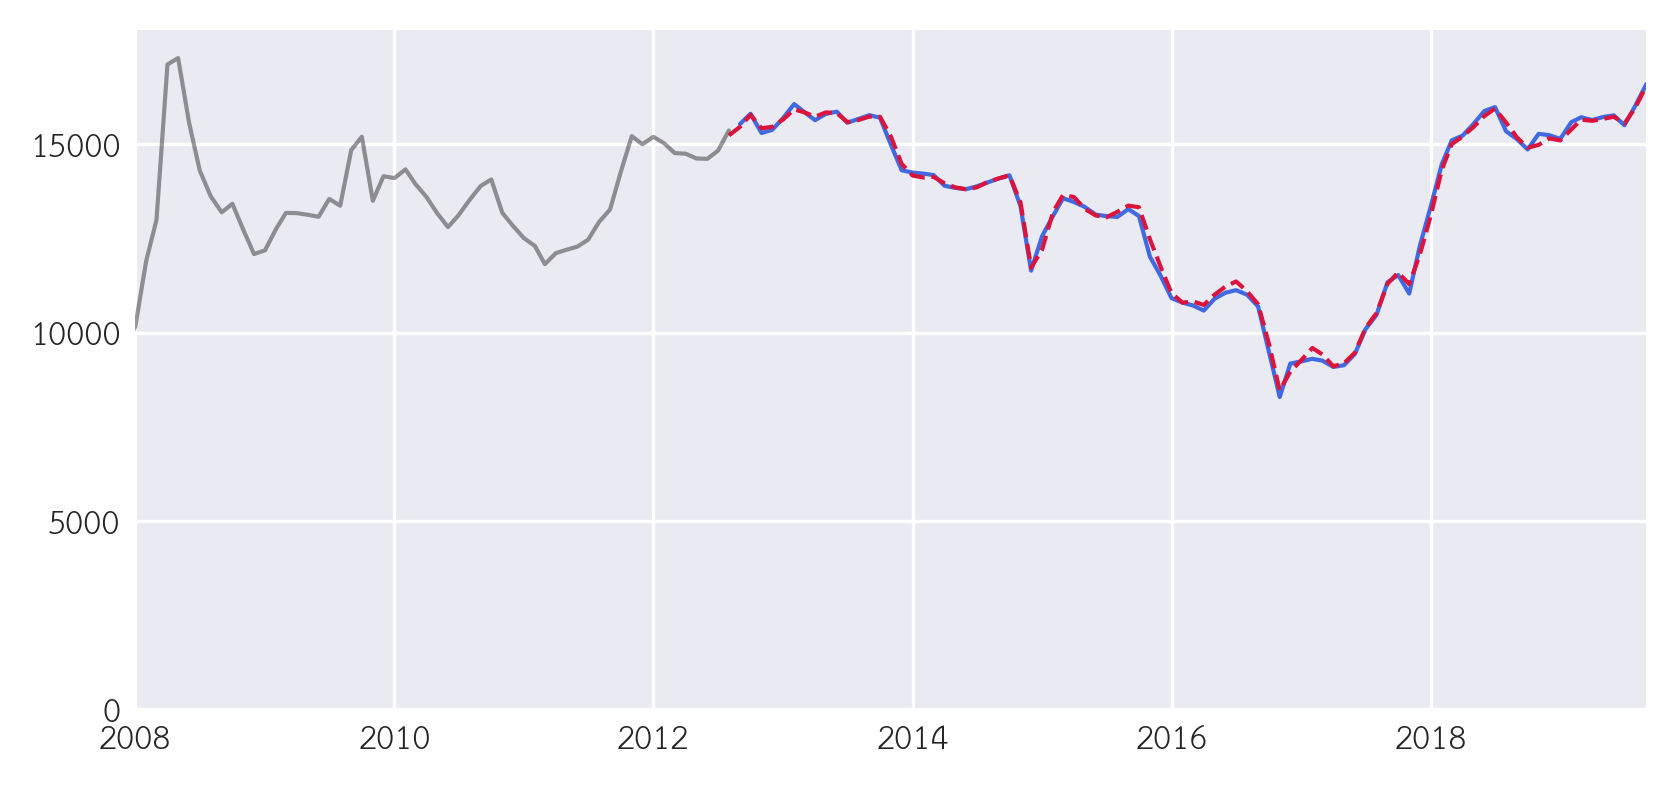

In [38]:
plot_fcast(hml, 'mlp', step=1)

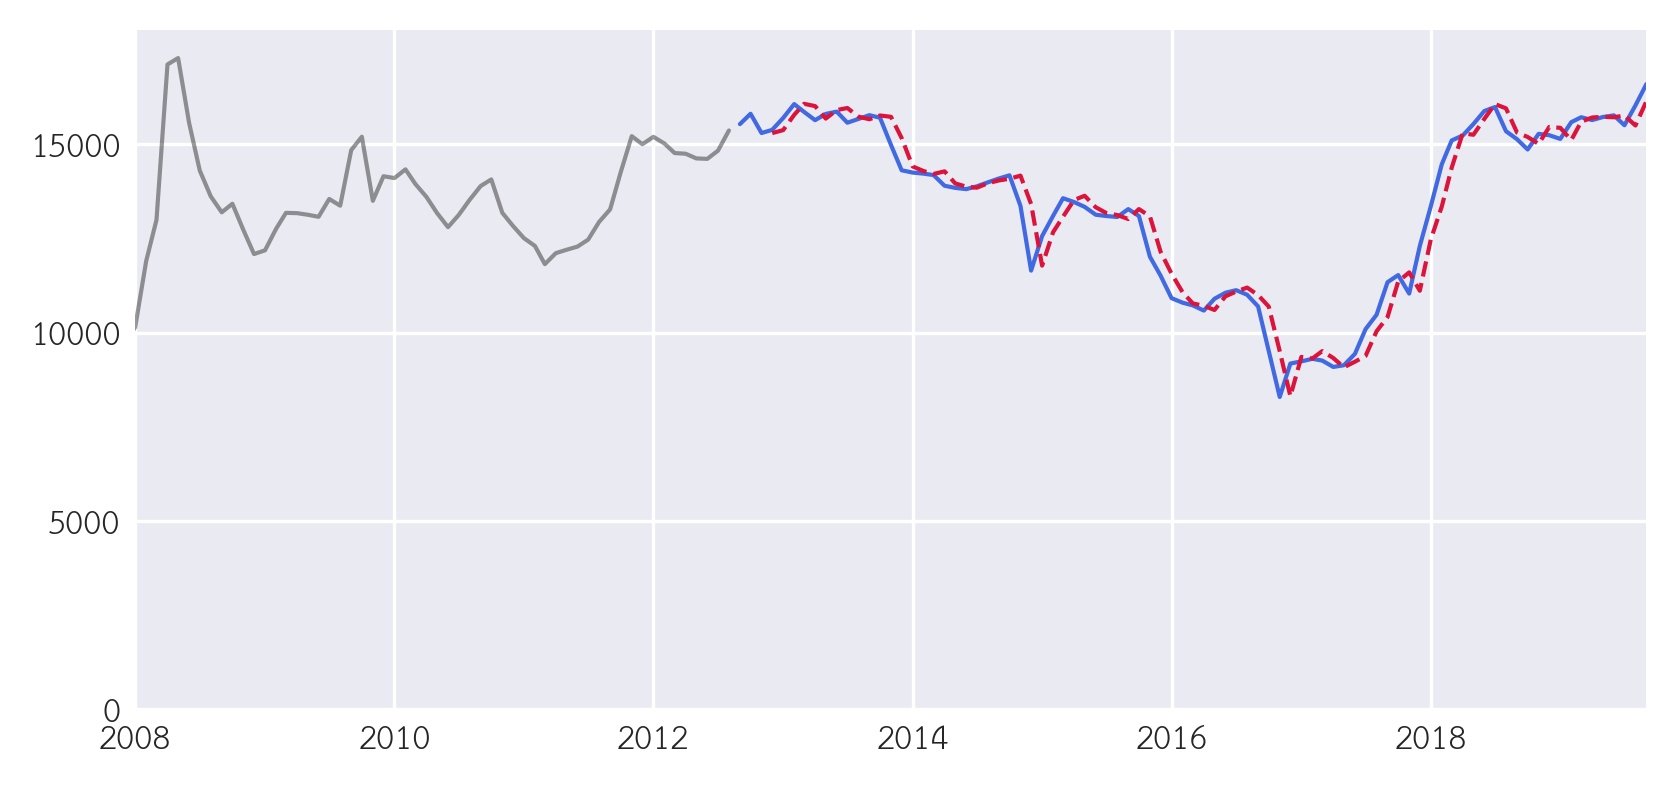

In [18]:
plot_fcast(hml, 'mlp', step=4)

In [15]:
model_measure(hml, hml.mlp_yhat, ['hml'])

,rmse,mae,mape
config,,,
hml,503.4071,348.8937,0.0284


In [14]:
model_measure(wht, wht.mlp_yhat, ['wht'])

,rmse,mae,mape
config,,,
wht,285.1482,217.2903,0.0270


In [13]:
model_measure(glu, glu.mlp_yhat, ['glu'])

,rmse,mae,mape
config,,,
glu,521.5118,374.8086,0.0343


In [ ]:
def mlp_fit(data, config, n_forecast=4, search_mode=False):
    
    # unpack config
    n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
    
    train, test = select_traintest(data, search_mode)
    
    # transform to kreas format
    x, y, date_idx = data_2keras(train, n_lag=n_lag, n_forecast=n_forecast)
    x = x.to_numpy()
    y = y.to_numpy()
    
    x_val, y_val, _ = data_2keras(test, n_lag=n_lag, n_forecast=n_forecast)
    x_val = x_val.to_numpy()
    y_val = y_val.to_numpy()
    
    # define model
    if n_layers!=1:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        
    else:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        
    # fit model
    model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0, validation_data=(x_val, y_val))
    return model

In [132]:
# mlp_configs[3]
config = (6, 1, 10, 200, 128, np.inf)
config

(6, 1, 10, 200, 128, inf)

In [133]:
npr.seed(1305)
history = mlp_fit(wht, config, search_mode=True)
res = history.history.history

In [122]:
val_mae = {}
val_mae[str(config)] = res['val_mae']

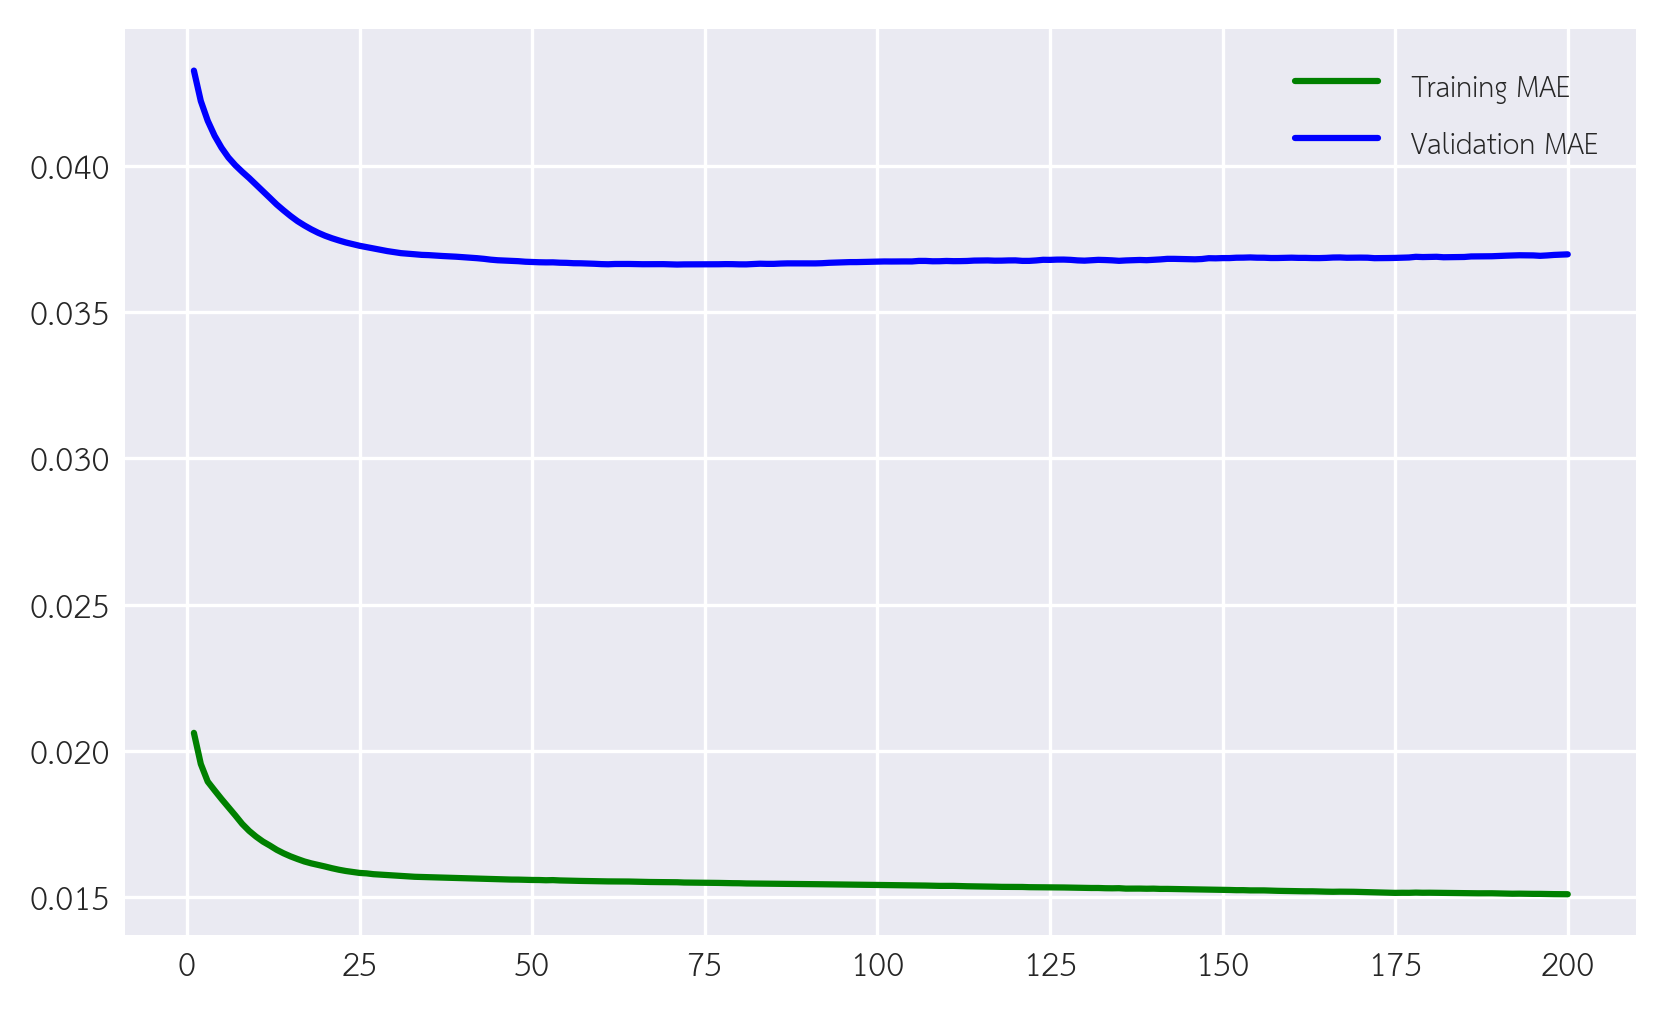

In [134]:
epochs = range(1, len(res['mae'])+1)

plt.plot(epochs, res['mae'], 'g', label='Training MAE')
plt.plot(epochs, res['val_mae'], 'b', label='Validation MAE')
plt.legend()

In [ ]:
def mlp_fit(data, config, n_forecast=4):

  # unpack config
  n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
  
  # transform to keras format
  data = data
  x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast)
  x = x.to_numpy()
  y = y.to_numpy()

  # define model
  if n_layers==3:
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')
  
  elif n_layers==2:
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')
    
  else:
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')

  # fit model
  model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)

  return model


def mlp_forecast(model_fitted, data, date, n_forecast=4):
  """
  Forecast MLP model

  Args:
      model_fitted (model): Keras fitted model
      data (dataframe): number of lags to be used in the model
      date (date): date when making the forecast
      n_forecast (int): number of steps to forecast

  Returns:

  """
  n_diff = getattr(data, "n_diff")
  scaler = getattr(data, "scaler")
  x_idx = data.scaled.index.get_loc(date)+1
  n_input = model_fitted.input_shape[1]

  # find-input
  x = data.scaled.iloc[x_idx-n_input:x_idx,]
  x_input = x.to_numpy().reshape(1,-1)

  # forecast
  yhat = model_fitted.predict(x_input, verbose=0).reshape(-1,)
  K.clear_session()
  df = pd.DataFrame(yhat,
                    columns=["yhat_scaled"],
                    index=pd.date_range(date, periods=n_forecast+1, freq='MS')[1:]
                   )
  df['yhat'] = scaler.inverse_transform(df)
  
  return df['yhat']